In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from spectral import SpectralNorm
import numpy as np
torch.manual_seed(0)

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 128, 128), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [3]:
# class Self_Attn(nn.Module):
#     """ Self attention Layer"""
#     def __init__(self, in_dim, activation):
#         super(Self_Attn,self).__init__()
#         self.chanel_in = in_dim
#         self.activation = activation
        
#         self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
#         self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
#         self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
#         self.gamma = nn.Parameter(torch.zeros(1))

#         self.softmax  = nn.Softmax(dim=-1) #
#     def forward(self,x):
#         """
#             inputs :
#                 x : input feature maps( B X C X W X H)
#             returns :
#                 out : self attention value + input feature 
#                 attention: B X N X N (N is Width*Height)
#         """
#         m_batchsize,C,width ,height = x.size()
#         proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
#         proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
#         energy =  torch.bmm(proj_query,proj_key) # transpose check
#         attention = self.softmax(energy) # BX (N) X (N) 
#         proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

#         out = torch.bmm(proj_value,attention.permute(0,2,1) )
#         out = out.view(m_batchsize,C,width,height)
        
#         out = self.gamma*out + x
#         return out, attention

In [4]:
# class Generator(nn.Module):
#     """Generator."""

#     def __init__(self, batch_size, image_size=128, z_dim=100, conv_dim=64):
#         super(Generator, self).__init__()
#         self.imsize = image_size
#         layer1 = []
#         layer2 = []
#         layer3 = []
#         last = []

#         repeat_num = int(np.log2(self.imsize)) - 3
#         mult = 2 ** repeat_num # 16
#         layer1.append(SpectralNorm(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
#         layer1.append(nn.BatchNorm2d(conv_dim * mult))
#         layer1.append(nn.ReLU())

#         curr_dim = conv_dim * mult

#         layer2.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
#         layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
#         layer2.append(nn.ReLU())

#         curr_dim = int(curr_dim / 2)

#         layer3.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
#         layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
#         layer3.append(nn.ReLU())

#         if self.imsize == 64:
#             layer4 = []
#             curr_dim = int(curr_dim / 2)
#             layer4.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
#             layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
#             layer4.append(nn.ReLU())
#             self.l4 = nn.Sequential(*layer4)
#             curr_dim = int(curr_dim / 2)

#         self.l1 = nn.Sequential(*layer1)
#         self.l2 = nn.Sequential(*layer2)
#         self.l3 = nn.Sequential(*layer3)

#         last.append(nn.ConvTranspose2d(curr_dim, 3, 4, 2, 1))
#         last.append(nn.Tanh())
#         self.last = nn.Sequential(*last)

#         self.attn1 = Self_Attn(128, 'relu')
#         self.attn2 = Self_Attn(64, 'relu')

#     def forward(self, z):
#         z = z.view(z.size(0), z.size(1), 1, 1)
#         out = self.l1(z)
#         out = self.l2(out)
#         out = self.l3(out)
#         out, p1 = self.attn1(out)
#         out = self.l4(out)
#         out, p2 = self.attn2(out)
#         out = self.last(out)

#         return out

In [5]:
# class Discriminator(nn.Module):
#     """Discriminator, Auxiliary Classifier."""

#     def __init__(self, batch_size=64, image_size=64, conv_dim=64):
#         super(Discriminator, self).__init__()
#         self.imsize = image_size
#         layer1 = []
#         layer2 = []
#         layer3 = []
#         last = []

#         layer1.append(SpectralNorm(nn.Conv2d(3, conv_dim, 4, 2, 1)))
#         layer1.append(nn.LeakyReLU(0.1))

#         curr_dim = conv_dim

#         layer2.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
#         layer2.append(nn.LeakyReLU(0.1))
#         curr_dim = curr_dim * 2

#         layer3.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
#         layer3.append(nn.LeakyReLU(0.1))
#         curr_dim = curr_dim * 2

#         if self.imsize == 64:
#             layer4 = []
#             layer4.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
#             layer4.append(nn.LeakyReLU(0.1))
#             self.l4 = nn.Sequential(*layer4)
#             curr_dim = curr_dim*2
#         self.l1 = nn.Sequential(*layer1)
#         self.l2 = nn.Sequential(*layer2)
#         self.l3 = nn.Sequential(*layer3)

#         last.append(nn.Conv2d(curr_dim, 1, 4))
#         self.last = nn.Sequential(*last)

#         self.attn1 = Self_Attn(256, 'relu')
#         self.attn2 = Self_Attn(512, 'relu')

#     def forward(self, x):
#         out = self.l1(x)
#         out = self.l2(out)
#         out = self.l3(out)
#         out,p1 = self.attn1(out)
#         out=self.l4(out)
#         out,p2 = self.attn2(out)
#         out=self.last(out)

#         return out.squeeze()

In [6]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 16, kernel_size=4, stride=1, padding=0),
            self.make_gen_block(hidden_dim * 16, hidden_dim * 8, kernel_size=2),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4, kernel_size=2),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=2),
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=4, padding=2),
            self.make_gen_block(hidden_dim, hidden_dim // 2, padding=2),
            self.make_gen_block(hidden_dim // 2, 3, kernel_size=2, final_layer=True)
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, padding=(1, 1), final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                SpectralNorm(nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=stride, padding=padding)),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=stride, padding=padding),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, im_chan):
        negative_slope = 0.1
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            SpectralNorm(nn.Conv2d(im_chan, 64, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(negative_slope),
            SpectralNorm(nn.Conv2d(64, 64, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(negative_slope),
            SpectralNorm(nn.Conv2d(64, 128, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(negative_slope),
            SpectralNorm(nn.Conv2d(128, 128, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(negative_slope),
            SpectralNorm(nn.Conv2d(128, 256, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(negative_slope),
            SpectralNorm(nn.Conv2d(256, 256, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(negative_slope),
            SpectralNorm(nn.Conv2d(256, 512, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(negative_slope)
        )
        self.fc = SpectralNorm(nn.Linear(4 * 4 * 512, 1))

    def forward(self, image):
        disc_pred = self.disc(image)
        return self.fc(disc_pred.view(-1, 4 * 4 * 512)).view(len(image), -1)

In [8]:
# class Discriminator(nn.Module):
#     '''
#     Discriminator Class
#     Values:
#       im_chan: the number of channels in the images, fitted for the dataset used, a scalar
#       hidden_dim: the inner dimension, a scalar
#     '''
#     def __init__(self, im_chan=3, hidden_dim=64):
#         super(Discriminator, self).__init__()
#         self.disc = nn.Sequential(
#             self.make_disc_block(im_chan, hidden_dim),
#             self.make_disc_block(hidden_dim, hidden_dim * 2),
#             self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
#         )

#     def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
#         '''
#         Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
#         a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
#         Parameters:
#             input_channels: how many channels the input feature representation has
#             output_channels: how many channels the output feature representation should have
#             kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
#             stride: the stride of the convolution
#             final_layer: a boolean, true if it is the final layer and false otherwise 
#                       (affects activation and batchnorm)
#         '''
#         if not final_layer:
#             return nn.Sequential(
#                 SpectralNorm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
#                 nn.BatchNorm2d(output_channels),
#                 nn.LeakyReLU(0.2, inplace=True),
#             )
#         else:
#             return nn.Sequential(
#                 nn.Conv2d(input_channels, output_channels, kernel_size, stride),
#             )

#     def forward(self, image):
#         '''
#         Function for completing a forward pass of the discriminator: Given an image tensor, 
#         returns a 1-dimension tensor representing fake/real.
#         Parameters:
#             image: a flattened image tensor with dimension (im_chan)
#         '''
#         disc_pred = self.disc(image)
#         return disc_pred.view(len(disc_pred), -1)

In [9]:
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels, num_classes=n_classes)

In [10]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    combined = torch.cat((x.float(), y.float()), dim=1)
    return combined

In [11]:
img_shape = (3, 128, 128)
n_classes = 4
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 128
display_step = 500
batch_size = 128
num_workers = 4
lr = 0.0002
device = 'cuda'

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])
dataset = ImageFolder('resized_emoji_challenge_128_faces/complete', transform=transform)
print(len(dataset))

36775


In [13]:
def dataset_split(dataset, val_split=0.2, test_split=0.2):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {'train': Subset(dataset, train_idx),
                'val': Subset(dataset, val_idx),
                'test': Subset(dataset, test_idx)}
    return datasets

In [14]:
datasets = dataset_split(dataset)
dataloaders = {x : DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in ['train', 'val', 'test']}

In [15]:
x, y = next(iter(dataloaders['train']))
print(x.shape, y.shape, sep='\n')

torch.Size([128, 3, 128, 128])
torch.Size([128])


In [16]:
def get_input_dimensions(z_dim, img_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        img_shape: the shape of each image as (C, W, H), which is (3, 256, 256)
        n_classes: the total number of classes in the dataset, an integer scalar (10)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
    '''
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = img_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [17]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, img_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
# gen = Generator(batch_size).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
# disc = Discriminator(batch_size).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [18]:
def weights_init(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
#         torch.nn.init.normal_(m.weight, 0.0, 0.02)
        try:
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias:
                torch.nn.init.xavier_uniform_(m.bias)
        except:
            pass
    if type(m) == nn.BatchNorm2d:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/230 [00:00<?, ?it/s]

Step 0: Generator loss: 0.0014179246425628663, discriminator loss: 0.0013852047920227051


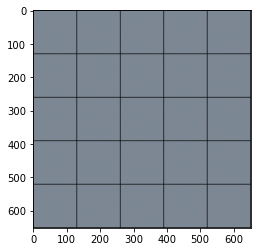

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


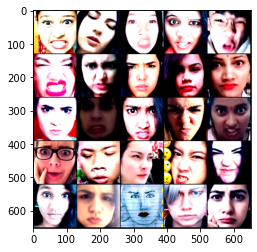

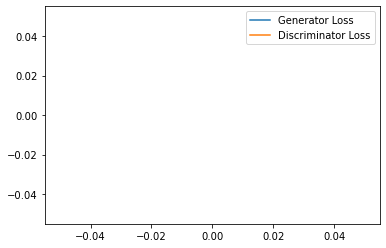

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

Step 500: Generator loss: 9.092110251426696, discriminator loss: 0.031942488745794154


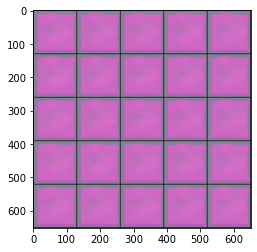

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


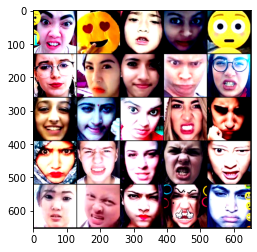

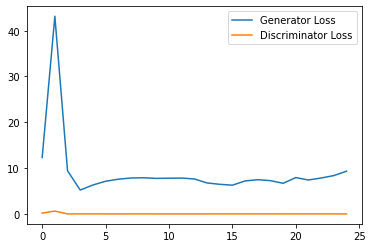

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

Step 1000: Generator loss: 9.034014810562134, discriminator loss: 0.0021980422715395208


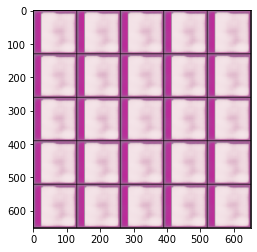

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


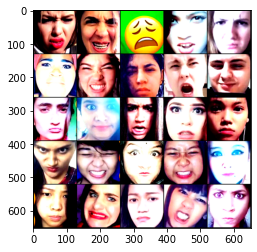

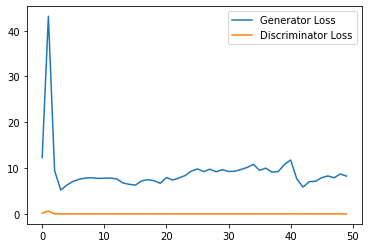

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

Step 1500: Generator loss: 8.294279014587403, discriminator loss: 0.003635719278851411


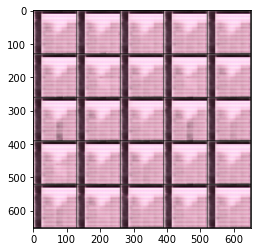

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


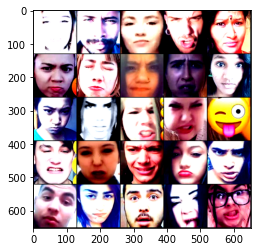

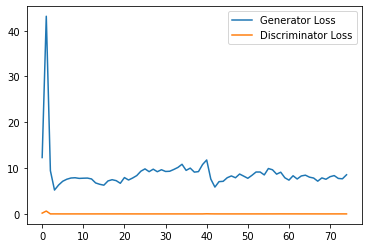

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

Step 2000: Generator loss: 4.4884698117014485, discriminator loss: 0.1227375188933147


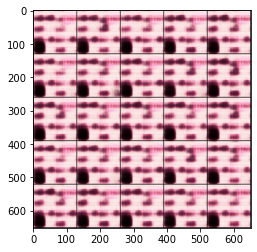

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


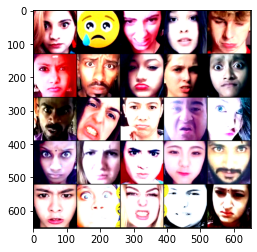

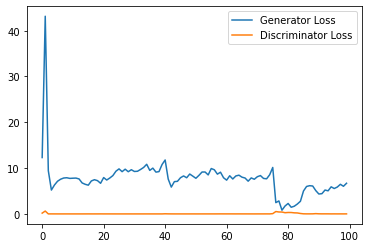

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

Step 2500: Generator loss: 5.910584911823273, discriminator loss: 0.010828448137981467


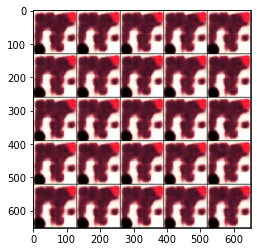

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


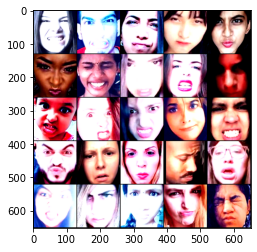

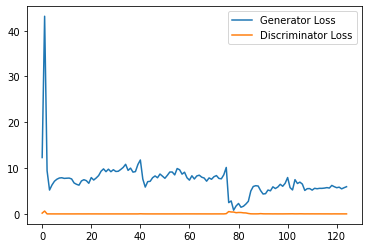

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

Step 3000: Generator loss: 6.133114170074463, discriminator loss: 0.004875624404114205


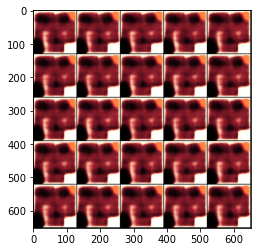

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


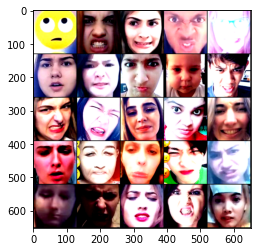

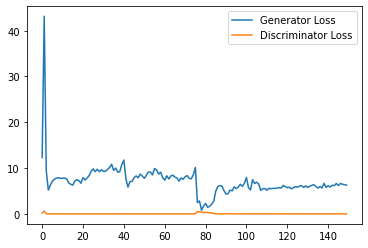

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

Step 3500: Generator loss: 6.925530049324036, discriminator loss: 0.003094720334498561


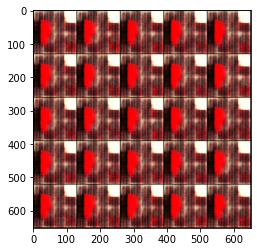

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


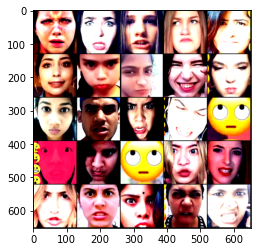

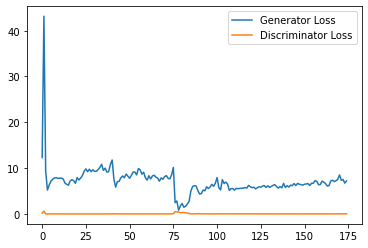

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

Step 4000: Generator loss: 7.705551705360413, discriminator loss: 0.0022165501597046387


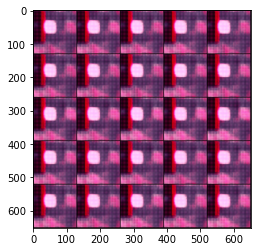

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


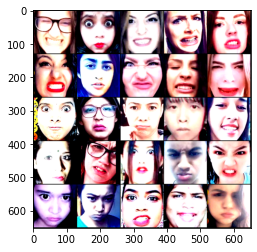

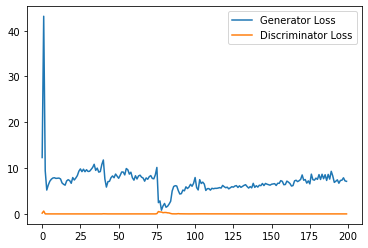

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

Step 4500: Generator loss: 7.844875770568848, discriminator loss: 0.002331200990935031


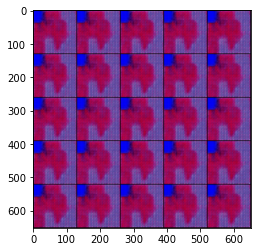

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


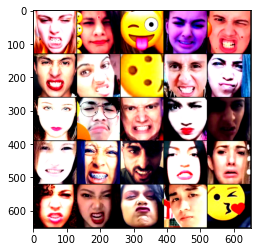

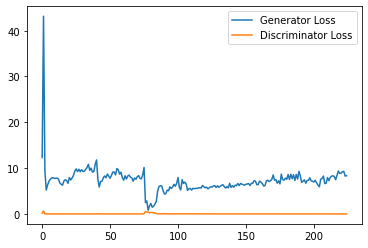

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

Step 5000: Generator loss: 7.473026122808457, discriminator loss: 0.011629401385558595


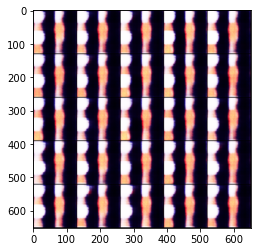

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


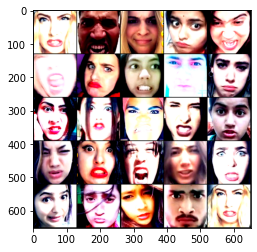

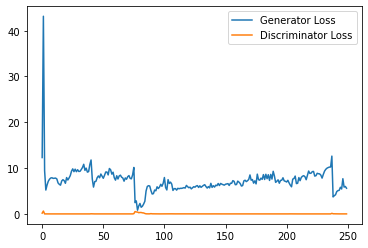

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

Step 5500: Generator loss: 6.656900489807129, discriminator loss: 0.004132971972270753


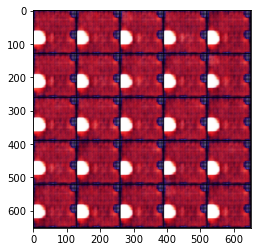

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


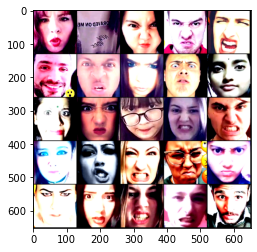

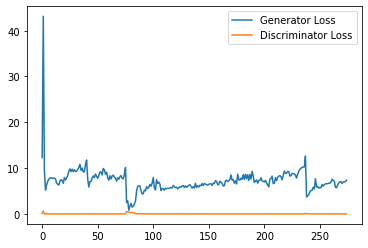

  0%|          | 0/230 [00:00<?, ?it/s]

OSError: [Errno 12] Cannot allocate memory

In [19]:
cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False
fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloaders['train']):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, img_shape[1], img_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
        # Get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
        
        # Make sure that enough images were generated
        assert len(fake) == len(real)
        # Check that correct tensors were combined
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        # It comes from the correct generator
        assert tuple(fake.shape) == (len(real), 3, 128, 128)

        # Get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred
        fake_image_and_labels = combine_vectors(fake.detach(), image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)
        
        # Make sure shapes are correct 
        assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], 128, 128)
        assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], 128, 128)
        # Make sure that enough predictions were made
        assert len(disc_real_pred) == len(real)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        # Shapes must match
        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(disc_fake_pred.shape) == tuple(disc_real_pred.shape)
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]

        if cur_step % display_step == 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1